# Building a Recommendation System using Word2Vec Model

### Authors: 
- Noa Oved, 308033653
- Shay Oved, 308033661

## Import libraries and load data

In [1]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
from time import time  # To time our operations
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('online_retail.csv')

## Explore the data

This Online Retail data set contains all purchases made for an online retail company based in the UK between the dates 01/12/2009 and 09/12/2011.
The company mainly sells unique all-occasion gift-ware.

In [3]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
df.dtypes

Invoice         object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price          float64
Customer ID    float64
Country         object
dtype: object

Given below is the description of the fields in this dataset:

1. __Invoice:__ Invoice number. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.

2. __StockCode:__ Product (item) code. A 5-digit integral number uniquely assigned to each distinct product.

3. __Description:__ Product (item) description

4. __Quantity:__ The quantities of each product (item) per transaction.

5. __InvoiceDate:__ Invoice date and time. The day and time when each transaction was generated.

6. __Price:__ Unit price. Product price per unit in sterling (Â£)

7. __Customer ID:__ Customer number. A 5-digit integral number uniquely assigned to each customer.

8. __Country:__ Country name. The name of the country where a customer resides.

In [5]:
df.shape

(1067371, 8)

The data contains 8 columns and 1,067,371 records.

## Prepare the data

#### Treat Missing Data

In [7]:
# check for missing values
df.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

<br>
Since we have sufficient data, we will drop all the rows with missing values

In [8]:
# remove missing values
df.dropna(inplace=True)

# again check missing values
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [9]:
df.shape

(824364, 8)

#### Remove non-relevant records

Remove rows with quantity less than zero- indicates a cancellation

In [10]:
df = df[~df['Invoice'].str.contains('C')]
df.shape

(805620, 8)

Remove rows that does not describe an item

In [11]:
df = df[~(df['StockCode'].str.contains('TEST'))]
df = df[~(df['Description'] == 'POSTAGE')]
df = df[~(df['StockCode'].str.contains('BANK'))]
df.shape

(803738, 8)

## Customers and items

The number of unique customers in our dataset

In [12]:
customers = df["Customer ID"].unique().tolist()
print('Number of uniqe users:', len(customers))

Number of uniqe users: 5878


The number of unique transaction in our dataset

In [13]:
transactions = df["Invoice"].unique().tolist()
print('Number of transaction:',len(transactions))

Number of transaction: 36823


The number of unique items in our dataset

In [14]:
items = df["StockCode"].unique().tolist()
print('Number of unique items:',len(items))

Number of unique items: 4627


The most popular items in the dataset

In [15]:
item_grouped = df.groupby(['Description']).agg({'StockCode': np.size}).reset_index().sort_values('StockCode', ascending = False)
item_grouped.rename(columns= {'StockCode':'Count'}, inplace = True)
item_grouped['percentage'] = (item_grouped['Count'] / item_grouped['Count'].sum())* 100
item_grouped.head(10)

,Description,Count,percentage
5043,WHITE HANGING HEART T-LIGHT HOLDER,5181,0.644613
3766,REGENCY CAKESTAND 3 TIER,3430,0.426756
291,ASSORTED COLOUR BIRD ORNAMENT,2777,0.345511
2390,JUMBO BAG RED RETROSPOT,2702,0.336179
3841,REX CASH+CARRY JUMBO SHOPPER,2141,0.266380
3153,PARTY BUNTING,2122,0.264016
2607,LUNCH BAG BLACK SKULL.,2117,0.263394
2620,LUNCH BAG SPACEBOY DESIGN,1941,0.241497
2244,HOME BUILDING BLOCK WORD,1929,0.240004
4610,STRAWBERRY CERAMIC TRINKET BOX,1922,0.239133


Average number of items in transaction

In [16]:
df.groupby(['Invoice']).agg({'StockCode': np.size})['StockCode'].mean()

21.827064606360157

Create a product-ID and product-description dictionary to easily map a product's description to its ID and vice versa

In [19]:
products = df[["StockCode", "Description"]]

# remove duplicates
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")

# create product-ID and product-description dictionary
products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()

In [20]:
# test the dictionary
products_dict['84029E']

['RED WOOLLY HOTTIE WHITE HEART.']

## Transform the data 

We will change the dataframe so that each line is a single user transaction

In [21]:
df_model = pd.DataFrame([],columns = ['Invoice','InvoiceDate','Customer ID','Transaction'])

for i in tqdm(transactions, position=0, leave=True):
    invoice = i
    invoicedate = set(df[df["Invoice"] == i]["InvoiceDate"]).pop()
    customer = set(df[df["Invoice"] == i]["Customer ID"]).pop()
    transaction = df[df["Invoice"] == i]["StockCode"].tolist()
    row = [invoice,invoicedate,customer,transaction]
    df_model = pd.concat([df_model,pd.DataFrame([row], columns = list(df_model.columns))], axis = 0) 

100%|██████████████████████████████████████████████████████████████████████████| 36823/36823 [1:34:32<00:00,  6.49it/s]


In [22]:
df_model.head()

,Invoice,InvoiceDate,Customer ID,Transaction
0,489434,2009-12-01 07:45:00,13085.0,"[85048, 79323P, 79323W, 22041, 21232, 22064, 2..."
0,489435,2009-12-01 07:46:00,13085.0,"[22350, 22349, 22195, 22353]"
0,489436,2009-12-01 09:06:00,13078.0,"[48173C, 21755, 21754, 84879, 22119, 22142, 22..."
0,489437,2009-12-01 09:08:00,15362.0,"[22143, 22145, 22130, 21364, 21360, 21351, 213..."
0,489438,2009-12-01 09:24:00,18102.0,"[21329, 21252, 21100, 21033, 20711, 21410, 214..."


We have 36,823 sequences of purchases

In [23]:
df_model.shape

(36823, 4)

In [24]:
df_model = df_model.sort_values(by=['InvoiceDate'])

## Split the data to Train, Validation and Test 

In [25]:
train = df_model.copy()
train = train.reset_index().drop(columns = ['index'])
validation = pd.DataFrame([], columns=list(train))
test = pd.DataFrame([], columns=list(train))

In [26]:
for c in tqdm(customers, position=0, leave=True):
    temp = train[train['Customer ID'] == c].sort_values(by=['InvoiceDate'])
    num = round(len(temp)*0.12)
    test = test.append(temp.tail(num))
    train.drop(temp.tail(num).index,inplace = True)
    

100%|█████████████████████████████████████████████████████████████████████████████| 5878/5878 [00:43<00:00, 134.72it/s]


In [27]:
for c in tqdm(customers, position=0, leave=True):
    temp = train[train['Customer ID'] == c].sort_values(by=['InvoiceDate'])
    num = round(len(temp)*0.23)
    validation = validation.append(temp.tail(num))
    train.drop(temp.tail(num).index,inplace = True)

100%|█████████████████████████████████████████████████████████████████████████████| 5878/5878 [00:40<00:00, 144.97it/s]


In [28]:
print('Precentage data in train:',len(train)/len(df_model)*100)
print('Precentage data in validation:',len(validation)/len(df_model)*100)
print('Precentage data in test:',len(test)/len(df_model)*100)

Precentage data in train: 70.67322054150938
Precentage data in validation: 19.221682100860875
Precentage data in test: 10.105097357629743


# Word2vec based Recommender System

**Model to learn embedding: Identify word and sentence equivalents from data**
<br>
In our model it can be imagined that each “item” is a “word”, and each "transaction is a "sentence”

Function that takes set of sentences and build a word2vec model

In [29]:
def word2vec_model(sentences,size,window,negative,sample):
    model = Word2Vec(size = size, # the dimensionality of the embedding vector
                     window = window, # the number of context words you are looking at
                     min_count=3, # Ignores all words with total absolute frequency lower than this number
                     sample=sample, # The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial
                     sg = 1, # whether to use skip-gram or CBOW- 1 is using skip-gram
                     hs = 0, # using negative sampling
                     negative = negative, # for negative sampling
                     alpha=0.03, #The initial learning rate 
                     min_alpha=0.0007) #Learning rate will linearly drop to min_alpha as training progresses
    t = time()
    model.build_vocab(sentences = sentences, # the list of split sentences
                      progress_per=200)
    print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))
    
    # train word2vec model
    t = time()
    model.train(train_model, total_examples = model.corpus_count, 
                epochs=30, report_delay=1)
    print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))
    
    # save word2vec model
    model.save("word2vec_2.model")
    # we do not plan to train the model any further, we are calling init_sims(), which will make the model much more memory-efficient
    model.init_sims(replace=True)
    print(model)
    word_vectors = model.wv
    
    return model,word_vectors   

## Recomandation methods

**1. Top K:**

Given a purchased product, the method calculates cosine similarities to all other products in the vocabulary and recommends the top K most similar products

Function that takes a product's vector as input and return top k similar products

In [30]:
def top_k_similar_products(vector,model,k):
    
    # extract most similar products for the input vector
    ms = model.similar_by_vector(vector, topn= k+1)[1:]
    ms_item = [i[0] for i in ms]
    
    # extract name of the similar products
    new_ms = []
    for j in ms_item:
        pair = products_dict[j][0]
        new_ms.append(pair)
        
    return new_ms        

Function that takes a product's vector as input and return top k similar products excluding the products that appear already in the transaction

In [1]:
def top_k_similar_products2(vector,model,transaction,k = 5):
    
    # extract most similar products for the input vector
    ms = model.similar_by_vector(vector, topn= k+len(transaction))[1:]
    ms_item = [i[0] for i in ms]
    
    for t in transaction:
        if t in ms_item:
            ms_item.remove(t)
    ms_item_k = ms_item[:k].copy()
    
    # extract name of the similar products
    new_ms = []
    for j in ms_item_k:
        pair = products_dict[j][0]
        new_ms.append(pair)
        
    return new_ms        

**2. Aggregate products:**

Recommend a product based on the multiple purchases that were in the transaction so far. 
Average the vectors corresponding to each product in the transaction, find a vector that is equidistant from all the products and use this resultant vector to find similar products.

Function that takes a list of product ID's and returns a vector which is the mean of vectors of the products in the input list

In [32]:
def aggregate_vectors(products,model):
    product_vec = []
    for i in products:
        product_vec.append(model[i])
    
    vector = np.mean(product_vec, axis=0)

    return vector

Function that takes a list of products as input and return top k similar products excluding the products in the list

In [43]:
def top_k_aggregate_vectors(products,model,k):
    
    vector = aggregate_vectors(products,model)
    # extract most similar products for the input vector
    ms = model.similar_by_vector(vector, topn= k+len(products))[:]
    ms_item = [i[0] for i in ms]
    
    for p in products:
        if p in ms_item:
            ms_item.remove(p)
    ms_item_k = ms_item[:k].copy()
    
    # extract name of the similar products
    new_ms = []
    for j in ms_item_k:
        pair = products_dict[j][0]
        new_ms.append(pair)
        
    return new_ms   

**3. Memory-based Item-based CF:**

Given a purchased product, the method recommends the top K most similar products according to Customer-Item Matrix

Function that takes a product and returns the top k similar products based on Customer-Item Matrix

In [123]:
def top_similar_items(item,k,item_item_sim_matrix):
    top_n = item_item_sim_matrix.loc[item].sort_values(ascending=False).iloc[1:k+1].index
    return list(top_n)

## Evaluation

Functions to calulate the measure precision@k

In [35]:
def calculate_precision_at_k(test,model,word_vectors,k, aggregate=False):
    cnt = 0
    correct = 0
    for t in test:
        items = []
        for j in range(len(t)-1):
            if t[j] in word_vectors.vocab: 
                cnt+=1
                if aggregate:
                    items.append(t[j])
                    recommand = top_k_aggregate_vectors(items,model,k)
                else:
                    recommand = top_k_similar_products(model[t[j]],model,k)
                if products_dict[t[j+1]][0] in recommand:
                    correct+=1
    return correct/cnt

In [36]:
def calculate_precision_at_k_CF(test,item_item_sim_matrix,k):
    cnt = 0
    correct = 0
    for t in test:
        for j in range(len(t)-1):
            if t[j] in item_item_sim_matrix.index: 
                cnt+=1
                recommand = top_similar_items(t[j],k,item_item_sim_matrix)
                if t[j+1] in recommand:
                    correct+=1
    return correct/cnt

# Create product recommendation system

In [37]:
train_model = train['Transaction'].tolist()
validation_model = validation['Transaction'].tolist()
test_model = test['Transaction'].tolist()

## Hyperparameter tuning

In [38]:
# max lenght of a sentence
max_sent = len(max(validation_model, key=len))
max_sent

542

**Hyperparameters for our model**

In [68]:
sizes = [50,100,150]
windows = [8,10,15,18,max_sent]
negatives = [10,15,20]
samples = [1e-2,1e-3,1e-4,1e-5]

In [69]:
gridsearch = pd.DataFrame([], columns = ['size','window','negative','sample','precision'])

cnt = 1
for size in sizes:
    for window in windows:
        for negative in negatives:
            for sample in samples:
                print('------------ Configuration Number',cnt,'------------')
                model,word_vectors = word2vec_model(train_model,size,window,negative,sample)
                precision = calculate_precision_at_k(validation_model,model,word_vectors,5)
                row = [size,window,negative,sample,precision]
                gridsearch = pd.concat([gridsearch,pd.DataFrame([row], columns = list(gridsearch), index=[cnt])], axis = 0) 
                cnt+=1

------------ Configuration Number 1 ------------
Time to build vocab: 0.02 mins
Time to train the model: 1.75 mins
Word2Vec(vocab=4325, size=50, alpha=0.03)
------------ Configuration Number 2 ------------
Time to build vocab: 0.02 mins
Time to train the model: 1.76 mins
Word2Vec(vocab=4325, size=50, alpha=0.03)
------------ Configuration Number 3 ------------
Time to build vocab: 0.02 mins
Time to train the model: 1.11 mins
Word2Vec(vocab=4325, size=50, alpha=0.03)
------------ Configuration Number 4 ------------
Time to build vocab: 0.02 mins
Time to train the model: 0.26 mins
Word2Vec(vocab=4325, size=50, alpha=0.03)
------------ Configuration Number 5 ------------
Time to build vocab: 0.02 mins
Time to train the model: 2.69 mins
Word2Vec(vocab=4325, size=50, alpha=0.03)
------------ Configuration Number 6 ------------
Time to build vocab: 0.02 mins
Time to train the model: 2.48 mins
Word2Vec(vocab=4325, size=50, alpha=0.03)
------------ Configuration Number 7 ------------
Time to b

------------ Configuration Number 53 ------------
Time to build vocab: 0.02 mins
Time to train the model: 13.18 mins
Word2Vec(vocab=4325, size=50, alpha=0.03)
------------ Configuration Number 54 ------------
Time to build vocab: 0.02 mins
Time to train the model: 13.13 mins
Word2Vec(vocab=4325, size=50, alpha=0.03)
------------ Configuration Number 55 ------------
Time to build vocab: 0.02 mins
Time to train the model: 5.88 mins
Word2Vec(vocab=4325, size=50, alpha=0.03)
------------ Configuration Number 56 ------------
Time to build vocab: 0.02 mins
Time to train the model: 0.78 mins
Word2Vec(vocab=4325, size=50, alpha=0.03)
------------ Configuration Number 57 ------------
Time to build vocab: 0.02 mins
Time to train the model: 16.97 mins
Word2Vec(vocab=4325, size=50, alpha=0.03)
------------ Configuration Number 58 ------------
Time to build vocab: 0.02 mins
Time to train the model: 16.87 mins
Word2Vec(vocab=4325, size=50, alpha=0.03)
------------ Configuration Number 59 -----------

------------ Configuration Number 105 ------------
Time to build vocab: 0.02 mins
Time to train the model: 6.25 mins
Word2Vec(vocab=4325, size=100, alpha=0.03)
------------ Configuration Number 106 ------------
Time to build vocab: 0.02 mins
Time to train the model: 6.25 mins
Word2Vec(vocab=4325, size=100, alpha=0.03)
------------ Configuration Number 107 ------------
Time to build vocab: 0.02 mins
Time to train the model: 3.54 mins
Word2Vec(vocab=4325, size=100, alpha=0.03)
------------ Configuration Number 108 ------------
Time to build vocab: 0.02 mins
Time to train the model: 0.71 mins
Word2Vec(vocab=4325, size=100, alpha=0.03)
------------ Configuration Number 109 ------------
Time to build vocab: 0.02 mins
Time to train the model: 10.08 mins
Word2Vec(vocab=4325, size=100, alpha=0.03)
------------ Configuration Number 110 ------------
Time to build vocab: 0.02 mins
Time to train the model: 10.07 mins
Word2Vec(vocab=4325, size=100, alpha=0.03)
------------ Configuration Number 111 

Time to build vocab: 0.02 mins
Time to train the model: 0.76 mins
Word2Vec(vocab=4325, size=150, alpha=0.03)
------------ Configuration Number 157 ------------
Time to build vocab: 0.02 mins
Time to train the model: 3.91 mins
Word2Vec(vocab=4325, size=150, alpha=0.03)
------------ Configuration Number 158 ------------
Time to build vocab: 0.02 mins
Time to train the model: 3.88 mins
Word2Vec(vocab=4325, size=150, alpha=0.03)
------------ Configuration Number 159 ------------
Time to build vocab: 0.02 mins
Time to train the model: 2.22 mins
Word2Vec(vocab=4325, size=150, alpha=0.03)
------------ Configuration Number 160 ------------
Time to build vocab: 0.02 mins
Time to train the model: 0.45 mins
Word2Vec(vocab=4325, size=150, alpha=0.03)
------------ Configuration Number 161 ------------
Time to build vocab: 0.02 mins
Time to train the model: 5.56 mins
Word2Vec(vocab=4325, size=150, alpha=0.03)
------------ Configuration Number 162 ------------
Time to build vocab: 0.02 mins
Time to t

In [70]:
gridsearch.sort_values('precision',ascending = False).head(5)

,size,window,negative,sample,precision
10,50,8,20,0.001,0.265883
98,100,18,10,0.001,0.265759
9,50,8,20,0.010,0.264928
86,100,15,10,0.001,0.264886
102,100,18,15,0.001,0.264796


**Hyperparameters for item2vec model**

In [96]:
# list to capture purchase history of the customers
#create sequences of purchases made by the customers in the dataset
train_item2vec = []

# populate the list with the product codes
for i in tqdm(set(train["Customer ID"]), position=0, leave=True):
    temp = train[train["Customer ID"] == i]["Transaction"].tolist()
    temp2 = [item for sublist in temp for item in sublist]
    train_item2vec.append(temp2)

100%|████████████████████████████████████████████████████████████████████████████| 5878/5878 [00:02<00:00, 2532.48it/s]


In [104]:
sizes = [50,100,150,200]
negatives = [10,15,20]
samples = [1e-2,1e-3,1e-4,1e-5]

In [105]:
gridsearch_item2vec = pd.DataFrame([], columns = ['size','negative','sample','precision'])

cnt = 1
for size in sizes:
    for negative in negatives:
        for sample in samples:
            print('------------ Configuration Number',cnt,'------------')
            model_item2vec,word_vectors_item2vec = word2vec_model(train_item2vec,size,max_sent,negative,sample)
            precision = calculate_precision_at_k(validation_model,model_item2vec,word_vectors_item2vec,5)
            row = [size,negative,sample,precision]
            gridsearch_item2vec = pd.concat([gridsearch_item2vec,pd.DataFrame([row], columns = list(gridsearch_item2vec), index=[cnt])], axis = 0) 
            cnt+=1

------------ Configuration Number 1 ------------
Time to build vocab: 0.01 mins
Time to train the model: 9.33 mins
Word2Vec(vocab=4325, size=50, alpha=0.03)
------------ Configuration Number 2 ------------
Time to build vocab: 0.02 mins
Time to train the model: 9.28 mins
Word2Vec(vocab=4325, size=50, alpha=0.03)
------------ Configuration Number 3 ------------
Time to build vocab: 0.02 mins
Time to train the model: 4.15 mins
Word2Vec(vocab=4325, size=50, alpha=0.03)
------------ Configuration Number 4 ------------
Time to build vocab: 0.02 mins
Time to train the model: 0.52 mins
Word2Vec(vocab=4325, size=50, alpha=0.03)
------------ Configuration Number 5 ------------
Time to build vocab: 0.02 mins
Time to train the model: 13.22 mins
Word2Vec(vocab=4325, size=50, alpha=0.03)
------------ Configuration Number 6 ------------
Time to build vocab: 0.02 mins
Time to train the model: 12.99 mins
Word2Vec(vocab=4325, size=50, alpha=0.03)
------------ Configuration Number 7 ------------
Time to

In [106]:
gridsearch_item2vec.sort_values('precision',ascending = False).head(5)

,size,negative,sample,precision
25,150,10,0.010,0.255236
26,150,10,0.001,0.255208
37,200,10,0.010,0.255180
38,200,10,0.001,0.254737
29,150,15,0.010,0.254613


## Quantitative comparison between our model to other models

We compare our model to Item-Based CF and Item2vec model using precision@k measure

Create a train set to each model

In [71]:
train_w2v = train_model+validation_model
train_i2v = train.append(validation)
train_cf = df[df['Invoice'].isin(set(list(train['Invoice'])+list(validation['Invoice'])))]

### Word2vec based Recommender System

In [78]:
model,word_vectors = word2vec_model(train_w2v,50,8,20,0.001)

Time to build vocab: 0.01 mins
Time to train the model: 3.36 mins
Word2Vec(vocab=4379, size=50, alpha=0.03)


#### TopK

In [79]:
# when not excluding the products that already appeared in the transaction
precision_5_word2vec = calculate_precision_at_k(test_model,model,word_vectors,5)
precision_5_word2vec

0.258311986863711

In [1011]:
# when excluding the products that already appeared in the transaction
# precision_e_5_word2vec = calculate_precision_at_k(test_model,model,word_vectors,5)
# precision_e_5_word2vec

0.24796059113300492

In [80]:
# when not excluding the products that already appeared in the transaction
precision_10_word2vec = calculate_precision_at_k(test_model,model,word_vectors,10)
precision_10_word2vec

0.31919868637110016

#### AggregateK - recommend based on the multiple purchases that were in the transaction so far

In [1019]:
# when not excluding the products that already appeared in the transaction
# precision2_5_word2vec = calculate_precision_at_k(test_model,model,word_vectors,5,True)
# precision2_5_word2vec

0.06895238095238095

In [81]:
# when excluding the products that already appeared in the transaction
precision2_5_word2vec = calculate_precision_at_k(test_model,model,word_vectors,5,True)
precision2_5_word2vec

0.0917832512315271

In [82]:
# when excluding the products that already appeared in the transaction
precision2_10_word2vec = calculate_precision_at_k(test_model,model,word_vectors,10,True)
precision2_10_word2vec

0.13485714285714287

### Qualitive Evaluation

We will try to see the quality of our recommendation model by passing the vector of the product '90019A' ('SILVER M.O.P ORBIT BRACELET')

In [182]:
products_dict['90019A']

['SILVER M.O.P ORBIT BRACELET']

In [135]:
top_k_similar_products(model['90019A'],model,5)

['SILVER M.O.P ORBIT DROP EARRINGS',
 'SILVER 2 STRAND NECKLACE-LEAF CHARM',
 'BLUE SHELL+SILVER NECKLACE',
 'PINK ROSEBUD & PEARL NECKLACE',
 'GOLD M.O.P ORBIT BRACELET']

### Visualize word2vec Embeddings

Now we will extract the vectors of all the words in our vocabulary and store it in one place for easy access.

In [60]:
# extract all vectors
X = model[model.wv.vocab]

X.shape

(4379, 100)

We visualize the embeddings we created. Over here we have 50 dimensional embeddings. We can't even visualize it. Therefore, we are going to reduce the dimensions of the product embeddings from 50 to 2 by using the UMAP algorithm, it is used for dimensionality reduction. Then, we will plot our result. 

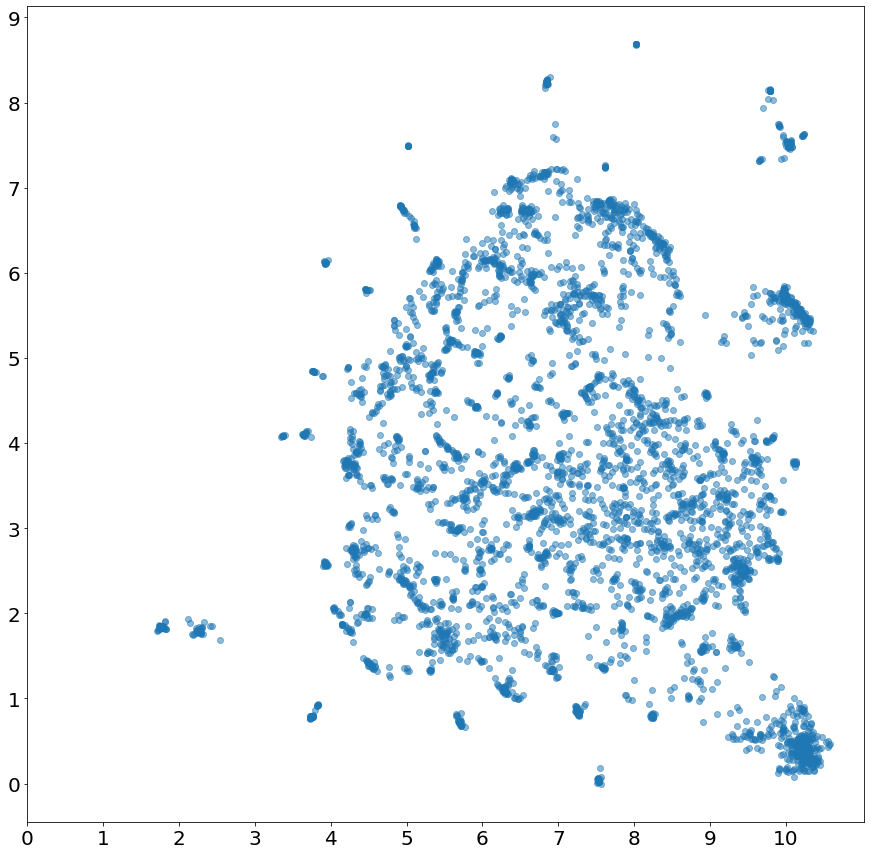

In [170]:
import umap

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(15,15))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], cmap='Spectral', marker = 'o', alpha=0.5)
plt.xticks(range(0,11,1),fontsize=20)
plt.yticks(range(0,10,1),fontsize=20)
plt.savefig('visualization.pdf', bbox_inches='tight')

Every dot in this plot is a product. There are several tiny clusters of these datapoints. These are groups of similar products. We will try to identify the isolated groups.

In [175]:
labels = [products_dict[i] for i in model.wv.vocab.keys()]
x = cluster_embedding[:, 0]
y = cluster_embedding[:, 1]

In [177]:
vis_embedding = pd.DataFrame([], columns = ['x','y','label'])
vis_embedding['x'] = x
vis_embedding['y'] = y
vis_embedding['label'] = labels

In [180]:
# Party items
list(vis_embedding[(vis_embedding['x']<3)]['label'])

[['WRAP ENGLISH ROSE '],
 ['WRAP BLUE RUSSIAN FOLKART'],
 ['GREETING CARD, THE BLACK CAT'],
 ['RAINY LADIES BIRTHDAY CARD'],
 ['BANQUET BIRTHDAY  CARD  '],
 ['SPACEBOY BIRTHDAY CARD'],
 ['RING OF ROSES BIRTHDAY CARD'],
 ['BOTANICAL LAVENDER BIRTHDAY CARD'],
 ['SKULLS AND CROSSBONES WRAP'],
 ['RED RETROSPOT WRAP '],
 ['SWALLOWS GREETING CARD'],
 ['PENNY FARTHING BIRTHDAY CARD'],
 ['WRAP, FRIENDSHIP ON GREEN'],
 ['ROBOT BIRTHDAY CARD'],
 ['DINOSAUR BIRTHDAY CARD'],
 ['PINK POLKADOT WRAP '],
 ['GREETING CARD, RITA'],
 ['VINTAGE CARAVAN GREETING CARD '],
 ['VINTAGE KID DOLLY CARD '],
 ['TEA PARTY BIRTHDAY CARD'],
 ['BLUE POLKADOT WRAP'],
 ['WRAP SUKI AND FRIENDS'],
 ['FANCY FONTS BIRTHDAY WRAP'],
 ['BLUE SCANDINAVIAN PAISLEY WRAP'],
 ['EMPIRE BIRTHDAY CARD'],
 ['WRAP PINK FAIRY CAKES '],
 ['SKULLS GREETING CARD'],
 ['FAIRY CAKE GREETINGS CARD'],
 ['TEA PARTY  WRAPPING PAPER '],
 ['ELEPHANT BIRTHDAY CARD '],
 ['GIN & TONIC DIET GREETING CARD '],
 ['BANK ACCOUNT  GREETING  CARD '],
 ['EMPIRE

In [183]:
# Jewelry items
list(vis_embedding[(vis_embedding['x']>9.5)&(vis_embedding['y']<0.5)]['label'])

[['PINK SWEETHEART BRACELET'],
 ['PURPLE SWEETHEART BRACELET'],
 ['BLUE SWEETHEART BRACELET'],
 ['BLACK SWEETHEART BRACELET'],
 ['BLACK DIAMANTE EXPANDABLE RING'],
 ['CRYSTAL PAIR HEART HAIR SLIDES'],
 ['OPULENT VELVET CANDLE IN BOX'],
 ['VINTAGE ROSE BEAD BRACELET BLUE'],
 ['WHITE GLASS CHUNKY CHARM BRACELET'],
 ['BLACK GEMSTONE BRACELET'],
 ['CARNIVAL BRACELET'],
 ['SILVER HOOP EARRINGS WITH FLOWER'],
 ['RASPBERRY ANT COPPER FLOWER NECKLAC'],
 ["NEW BAROQUE B'FLY NECKLACE RED"],
 ['FLOWER GLASS GARLAND NECKL.36"BLACK'],
 ['TURQUOISE BERTIE GLASS BEAD CHARM'],
 ['FRESHWATER PEARL BRACELET PINK'],
 ['FRESHWATER PEARL BRACELET GOLD'],
 ['PEARL & SHELL 42"NECKL. IVORY'],
 ['PEARL & SHELL 42"NECKL. PINK'],
 ['LONG SILVER NECKLACE PASTEL FLOWER'],
 ['SILVER CHARM NECKLACE 70CM'],
 ['BLACK+WHITE NECKLACE W TASSEL'],
 ['CHUNKY SILVER NECKLACE PASTEL FLOWE'],
 ['FLOWER BURST SILVER RING GREEN'],
 ['FLOWER BURST SILVER RING ROSE'],
 ['FLOWER BURST SILVER RING CRYSTAL'],
 ["FLOWER BURST SILVER 

### Item2vec based Recommender System

In item2vec model it can be imagined that each “item” is a “word”, and the buying history of a user is a "sentence”


In [107]:
# list to capture purchase history of the customers
#create sequences of purchases made by the customers in the dataset
train_item2vec = []

# populate the list with the product codes
for i in tqdm(set(train_i2v["Customer ID"]), position=0, leave=True):
    temp = train_i2v[train_i2v["Customer ID"] == i]["Transaction"].tolist()
    temp2 = [item for sublist in temp for item in sublist]
    train_item2vec.append(temp2)

100%|████████████████████████████████████████████████████████████████████████████| 5878/5878 [00:02<00:00, 2479.81it/s]


In [108]:
# max lenght of a sentence
max_sent_item2vec = len(max(train_item2vec, key=len))
max_sent_item2vec

10693

In [109]:
model_item2vec,word_vectors_item2vec = word2vec_model(train_item2vec,150,max_sent_item2vec,10,0.001)

Time to build vocab: 0.01 mins
Time to train the model: 12.83 mins
Word2Vec(vocab=4379, size=150, alpha=0.03)


In [110]:
precision_5_item2vec = calculate_precision_at_k(test_model,model_item2vec,word_vectors_item2vec,5)
precision_5_item2vec

0.24179967159277505

In [111]:
precision_10_item2vec = calculate_precision_at_k(test_model,model_item2vec,word_vectors_item2vec,10)
precision_10_item2vec

0.2966699507389163

### Memory-based Item-based Collaborative Filtering

Create a Customer-Item Matrix

In [88]:
customer_item_matrix = train_cf.pivot_table(index='Customer ID',columns='StockCode',values='Quantity',aggfunc='sum')

In [89]:
# One Hot Encoding: We apply lambda function to convert anything above zero to 1 and zero to 0
customer_item_matrix = customer_item_matrix.applymap(lambda x: 1 if x>0 else 0)

In [90]:
item_item_sim_matrix = pd.DataFrame(cosine_similarity(customer_item_matrix.T))

In [91]:
item_item_sim_matrix.columns = customer_item_matrix.T.index
item_item_sim_matrix['StockCode'] = customer_item_matrix.T.index
item_item_sim_matrix = item_item_sim_matrix.set_index('StockCode')

In [92]:
item_item_sim_matrix.head()

StockCode,10002,10080,10109,10120,10123C,10123G,10124A,10124G,10125,10133,...,90214Y,90214Z,ADJUST,ADJUST2,C2,D,DOT,M,PADS,SP1002
StockCode,,,,,,,,,,,,,,,,,,,,,
10002,1.000000,0.033296,0.0,0.079731,0.075023,0.045083,0.147242,0.078087,0.102240,0.064848,...,0.0,0.034922,0.046852,0.045083,0.011641,0.0,0.0,0.140313,0.0,0.110432
10080,0.033296,1.000000,0.0,0.031099,0.034139,0.061546,0.050252,0.000000,0.069786,0.035411,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.051770,0.0,0.000000
10109,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083045,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.048564,0.0,0.000000
10120,0.079731,0.031099,0.0,1.000000,0.046714,0.084215,0.068761,0.048622,0.063661,0.036340,...,0.0,0.000000,0.029173,0.000000,0.000000,0.0,0.0,0.092090,0.0,0.103142
10123C,0.075023,0.034139,0.0,0.046714,1.000000,0.323575,0.075485,0.053376,0.157243,0.013298,...,0.0,0.000000,0.032026,0.000000,0.000000,0.0,0.0,0.085542,0.0,0.000000


In [126]:
precision_5_CF = calculate_precision_at_k_CF(test_model,item_item_sim_matrix,5)
precision_5_CF

0.25784644465155354

In [127]:
precision_10_CF = calculate_precision_at_k_CF(test_model,item_item_sim_matrix,10)
precision_10_CF

0.3172444572793741

### Results

In [140]:
res = pd.DataFrame([], columns = ['Model','Precision@5','Precision@10'])
res = res.append(pd.DataFrame([['Word2Vec topk',precision_5_word2vec,precision_10_word2vec]],columns = list(res)))
res = res.append(pd.DataFrame([['Word2Vec aggregatek',precision2_5_word2vec,precision2_10_word2vec]],columns = list(res)))
res = res.append(pd.DataFrame([['Item2Vec',precision_5_item2vec,precision_10_item2vec]],columns = list(res)))
res = res.append(pd.DataFrame([['CF Item Based',precision_5_CF,precision_10_CF]],columns = list(res)))

res

,Model,Precision@5,Precision@10
0,Word2Vec topk,0.258312,0.319199
0,Word2Vec aggregatek,0.091783,0.134857
0,Item2Vec,0.241800,0.296670
0,CF Item Based,0.257846,0.317244
